In [1]:
# Ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#### I have used locality sensitive hashing(LSH) to create a hash for the given image and then compare the distance from image embedding of the pictures of the given dataset which shares the same hash value. In this way, instead of doing similarity search over the whole dataset, it will only do a similarity search with a subset of images which shares the same hash value with the input image.

## Package used for LSH:  lshashpy3
##### Link: https://pypi.org/project/lshashpy3/

In [2]:
!pip install lshashpy3

  Created wheel for lshashpy3: filename=lshashpy3-0.0.8-py3-none-any.whl size=8877 sha256=0dbe4186db93285ebe05f94d725933cab5d1ac831b3be34653c495196f598c6c
  Stored in directory: /root/.cache/pip/wheels/32/9b/ae/27f94ba2cd85b1cd5af645fa78f90b703c9e1fb9e2b55a04e0
Successfully built lshashpy3
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## The task is broken down in the following steps:

#####  1) Transfer learning from a ResNet50 model(trained on ImageNet) using FastAI and Pytorch.
#####  2) Take the output of second last fully connected layer from trained ResNet50 model to get embedding for all images.
#####  3) Use Locality Sensitive hashing to create LSH hashing for our image embedding which enables fast approximate nearest neighbor search
#####  4) Then given an image, we can convert it into image embedding using our trained model and then search similar images using Approximate nearest neighbor on the given dataset

## Importing libaries

In [28]:
import pandas as pd
import pickle
import numpy as np
from fastai.vision import *
from fastai.callbacks.hooks import *

from fastai.vision.image import pil2tensor, Image
import matplotlib.pyplot as plt
from lshashpy3 import LSHash
from PIL import Image as pil_img
from tqdm import tqdm_notebook
pd.set_option('display.max_columns', 500)


In [4]:
path = Path('../input/similar-images-in-dataset/data/dataset/')

## Loading Data

In [5]:
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=0, 
    max_lighting=0, 
    max_zoom=1, 
    max_warp=0
)
data = (ImageList.from_folder(path)
        .random_split_by_pct(0.2)
        .label_from_folder()
        .transform(tfms=tfms, size=512)
        .databunch(bs=16))

/opt/conda/lib/python3.7/site-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [6]:
print('Train dataset size: {0}'.format(len(data.train_ds.x)))
print('Test dataset size: {0}'.format(len(data.valid_ds.x)))

Train dataset size: 3791
Test dataset size: 947


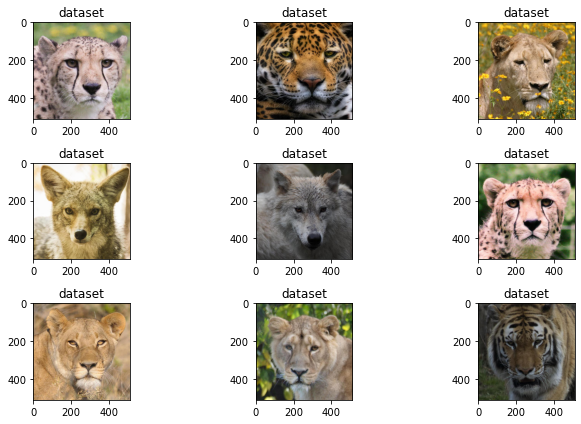

In [7]:
## Show sample data
data.show_batch(rows=3, figsize=(10,6), hide_axis=False)

## Load Model

In [8]:
## Creating the model
learn = create_cnn(data, models.resnet50, pretrained=True, metrics=accuracy)

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


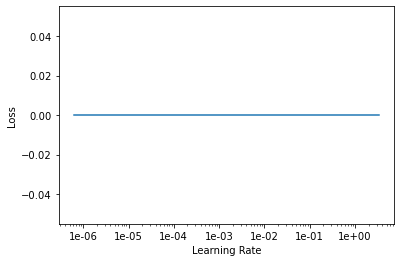

In [9]:
## Finding Ideal learning late
learn.model_dir  ='/kaggle/output/'
learn.lr_find()
learn.recorder.plot()

In [10]:
## Fitting 5 epochs
learn.fit_one_cycle(5,1e-2)

In [11]:
## Saving stage 1
learn.save('stg1-rn34')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


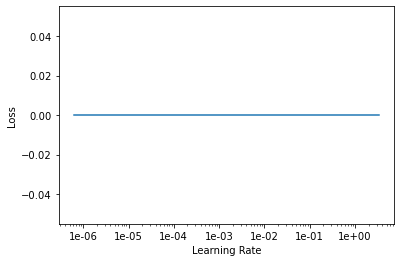

In [12]:
## Unfreeing layer and finding ideal learning rate
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [13]:
## Fitting 5 epochs
learn.fit_one_cycle(5, slice(1e-5, 1e-2/5))

In [14]:
## Saving model weights
learn.save('stg2-rn34')

## Extracting Feature

Creating a hook right after convolutional part of resnet 50 and max pooling layer which generates a vector for a particular image of 512*512.

In [15]:
# this is a hook (Reference: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(learn.model[1][5]) ## Output before the last FC layer

Creating Feature Vector

In [16]:
## By running this feature vectors would be saved in sf variable initated above
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

Converting in a dictionary of {img_path:featurevector}

In [17]:
img_path = [str(x) for x in (list(data.train_ds.items)+list(data.valid_ds.items))]
feature_dict = dict(zip(img_path,sf.features))

In [18]:
## Exporting as pickle

file = "feature_dict.p"
with open(file,mode='wb') as feature_f:
    pickle.dump(feature_dict,feature_f)

## Using Locality Sensitive Hashing to find near similar images

In [19]:
## Loading Feature dictionary

with open(file,mode='rb') as feature_f:
    feature_dict = pickle.load(feature_f)
# feature_dict = pickle.load(open(path/'feature_dict.p','rb'))

In [20]:
## Locality Sensitive Hashing
# params
k = 10 # hash size
L = 5  # number of tables
d = 512 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for img_path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec.flatten(), extra_data=img_path)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [21]:
## Exporting as pickle

lsh_file = "lsh.p"
with open(lsh_file,mode='wb') as lsh_f:
    pickle.dump(lsh,lsh_f)

## Visualizing Output

## Get similar image by giving index of the image in LSH

In [29]:
# Loading Feature dictionary

with open(file,mode='rb') as feature_f:
    feature_dict = pickle.load(feature_f)
    
with open(lsh_file,mode='rb') as lsh_f:
    lsh = pickle.load(lsh_f)

def get_similar_item(idx, feature_dict, lsh_variable, n_items):
    response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
                     num_results=n_items+2, distance_func='hamming')
    input_img=response[0][0][1]
    print("Input Image Path= ", input_img)
    response=response[1:]
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    
    fig=plt.figure(figsize=(2*rows, 3*rows))
    
    inp_img = pil_img.open(input_img)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(inp_img)
    

    j=4
    for i in range(1, columns*rows +1):     
        if i<n_items+2:
            img = pil_img.open(response[i-1][0][1])
            fig.add_subplot(rows , columns, j)
            plt.imshow(img)
        j=j+1
    return plt.show()

Input Image Path=  ../input/similar-images-in-dataset/data/dataset/629.jpg


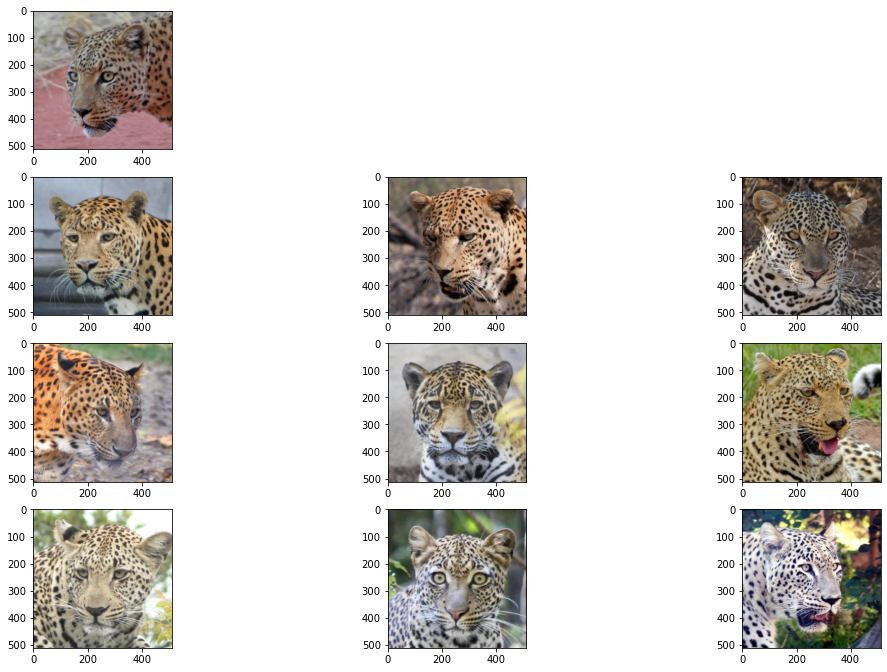

In [30]:
get_similar_item(50, feature_dict, lsh,8)

Input Image Path=  ../input/similar-images-in-dataset/data/dataset/2135.jpg


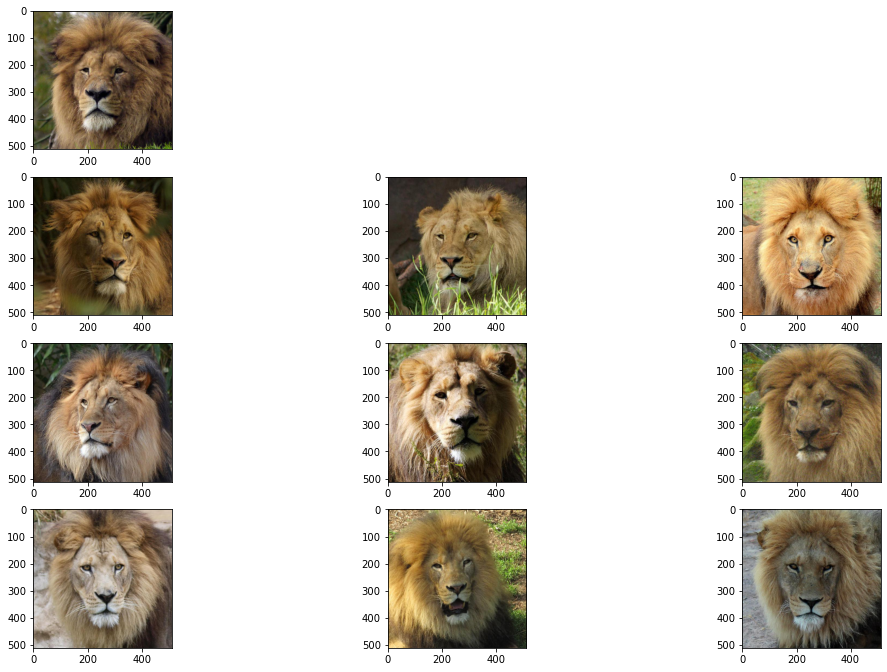

In [31]:
get_similar_item(40, feature_dict, lsh,8)

Input Image Path=  ../input/similar-images-in-dataset/data/dataset/3231.jpg


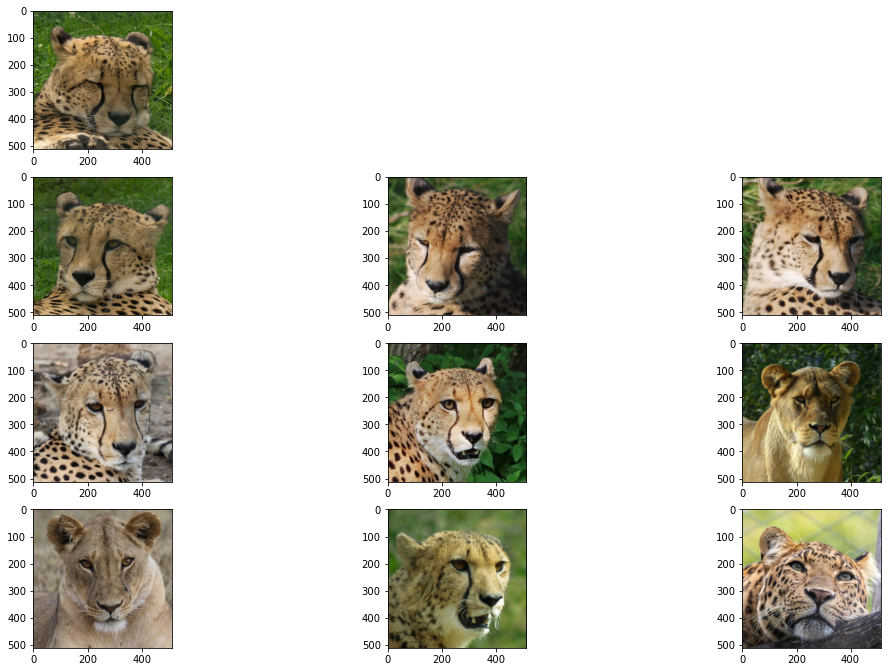

In [32]:
get_similar_item(1000, feature_dict, lsh,8)

Input Image Path=  ../input/similar-images-in-dataset/data/dataset/2943.jpg


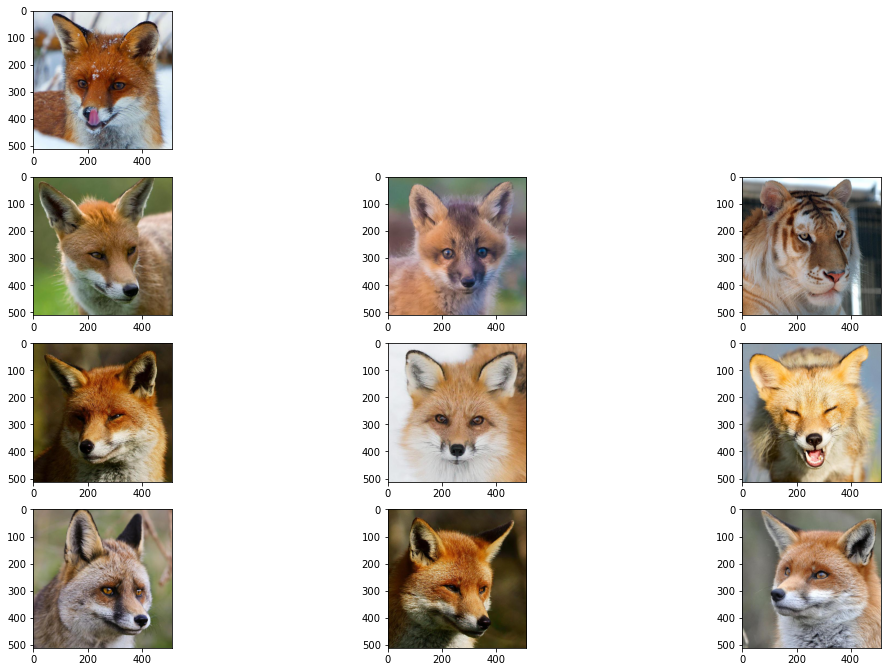

In [33]:
get_similar_item(3000, feature_dict, lsh,8)

## Get similar images to the given Input Image

In [34]:
IMAGE_PATH='../input/similar-images-in-dataset/data/dataset/2.jpg'
input_img = pil_img.open(IMAGE_PATH)

In [35]:
def image_to_vec(url_img, hook, learner):
    '''
    Function to convert image to vector
    '''
    print("Convert image to vec")
    _ = learner.predict(Image(pil2tensor(url_img, np.float32).div_(255)))
    vect = hook.features[-1]
    return vect

In [36]:
vect = image_to_vec(input_img, sf, learn)

Convert image to vec
********** done *************


In [37]:
def get_similar_item_input(idx, feature_dict, lsh_variable, n_items):
    response = lsh_variable.query(vect,  num_results=n_items+2, distance_func='hamming')
#     lsh.query(vect, num_results=n_items + 1, distance_func="hamming")
    input_img=response[0][0][1]
    print("Input Image Path= ", input_img)
    response=response[1:]
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    
    fig=plt.figure(figsize=(2*rows, 3*rows))
    
    inp_img = pil_img.open(input_img)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(inp_img)
    

    j=4
    for i in range(1, columns*rows +1):     
        if i<n_items+2:
            img = pil_img.open(response[i-1][0][1])
            fig.add_subplot(rows , columns, j)
            plt.imshow(img)
        j=j+1
    return plt.show()

Input Image Path=  ../input/similar-images-in-dataset/data/dataset/2.jpg


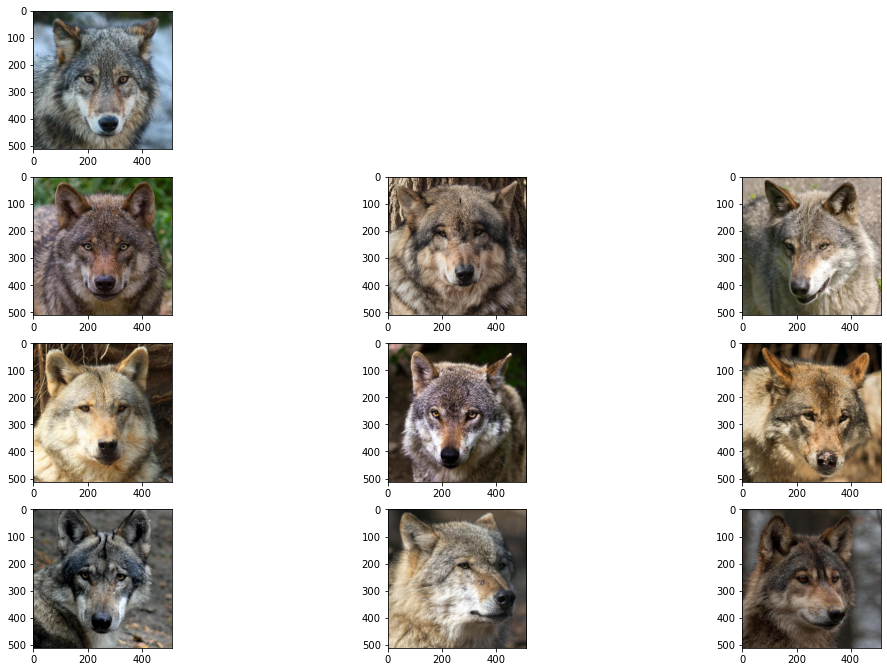

In [38]:
get_similar_item_input(vect, feature_dict, lsh,8)

> ## Clustering using KMeans and an t-SNE

In [39]:
from sklearn.cluster import KMeans

In [40]:
# get the feature vector into a list
feature_vect=list(feature_dict.values())

In [41]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=42).fit(feature_vect)
Y=kmeans.labels_

In [42]:
from sklearn.manifold import TSNE
import numpy as np
import glob, json, os

chart_data = []

# build the tsne model on the image vectors

print('*******building tsne model************')
model = TSNE(n_components=2,random_state=42, verbose=1)
np.set_printoptions(suppress=True)
tsne_model = model.fit_transform(feature_vect)

*******building tsne model************
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4738 samples in 0.710s...
[t-SNE] Computed neighbors for 4738 samples in 28.416s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4738
[t-SNE] Computed conditional probabilities for sample 2000 / 4738
[t-SNE] Computed conditional probabilities for sample 3000 / 4738
[t-SNE] Computed conditional probabilities for sample 4000 / 4738
[t-SNE] Computed conditional probabilities for sample 4738 / 4738
[t-SNE] Mean sigma: 3.986318
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.273270
[t-SNE] KL divergence after 1000 iterations: 2.143146


In [43]:
image_path=list(feature_dict.keys())

In [44]:
"""The variable tsne contains an array of unnormalized 2d points, corresponding to the embedding.
In the next cell, we normalize the embedding so that lies entirely in the range (0,1)."""

tx, ty = tsne_model[:,0], tsne_model[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

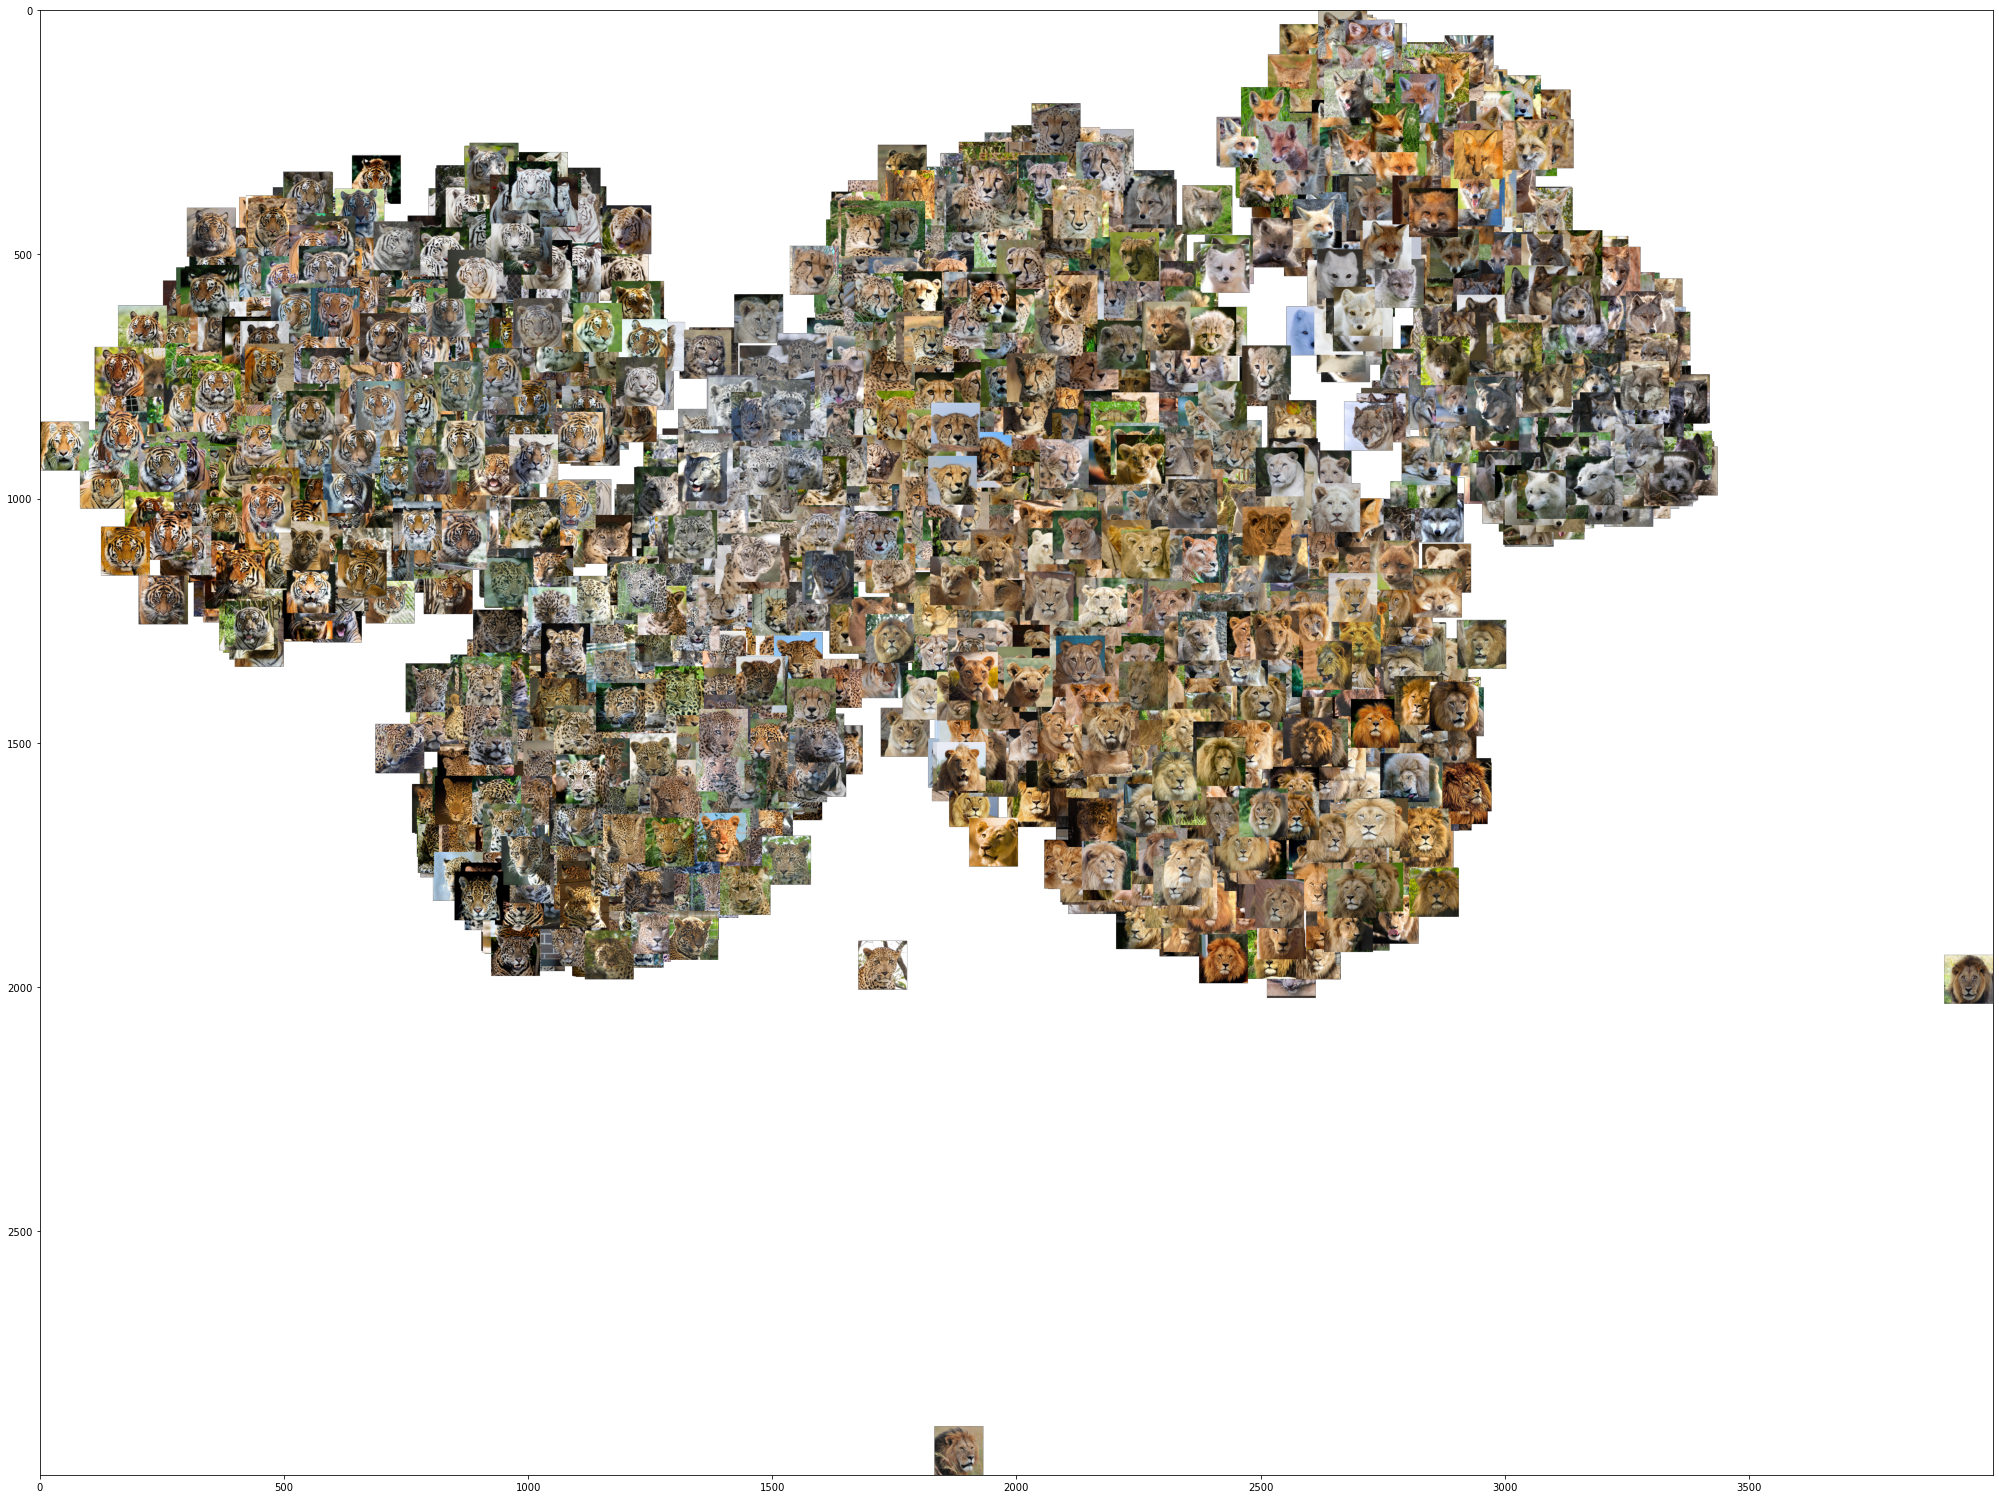

In [46]:
width = 4000
height = 3000
max_dim = 100

full_image = pil_img.new('RGBA', (width, height))
for img, x, y in zip(image_path, tx, ty):
    tile = pil_img.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), pil_img.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (35,35))
plt.imshow(full_image)

### Plotting Scatter Plot to Visualize the cluster

In [47]:
import seaborn as sns

In [48]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 9))

    # We create a scatter plot.
    f = plt.figure(figsize=(20, 20))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=120, c=palette[colors.astype(np.int)], label=colors)
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    return f, ax, sc

[0, 1, 2, 3, 4, 5, 6]


(<Figure size 2304x2304 with 1 Axes>,
 <matplotlib.collections.PathCollection at 0x7efdbd601c10>)

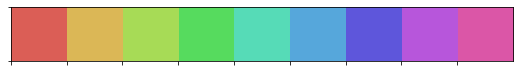

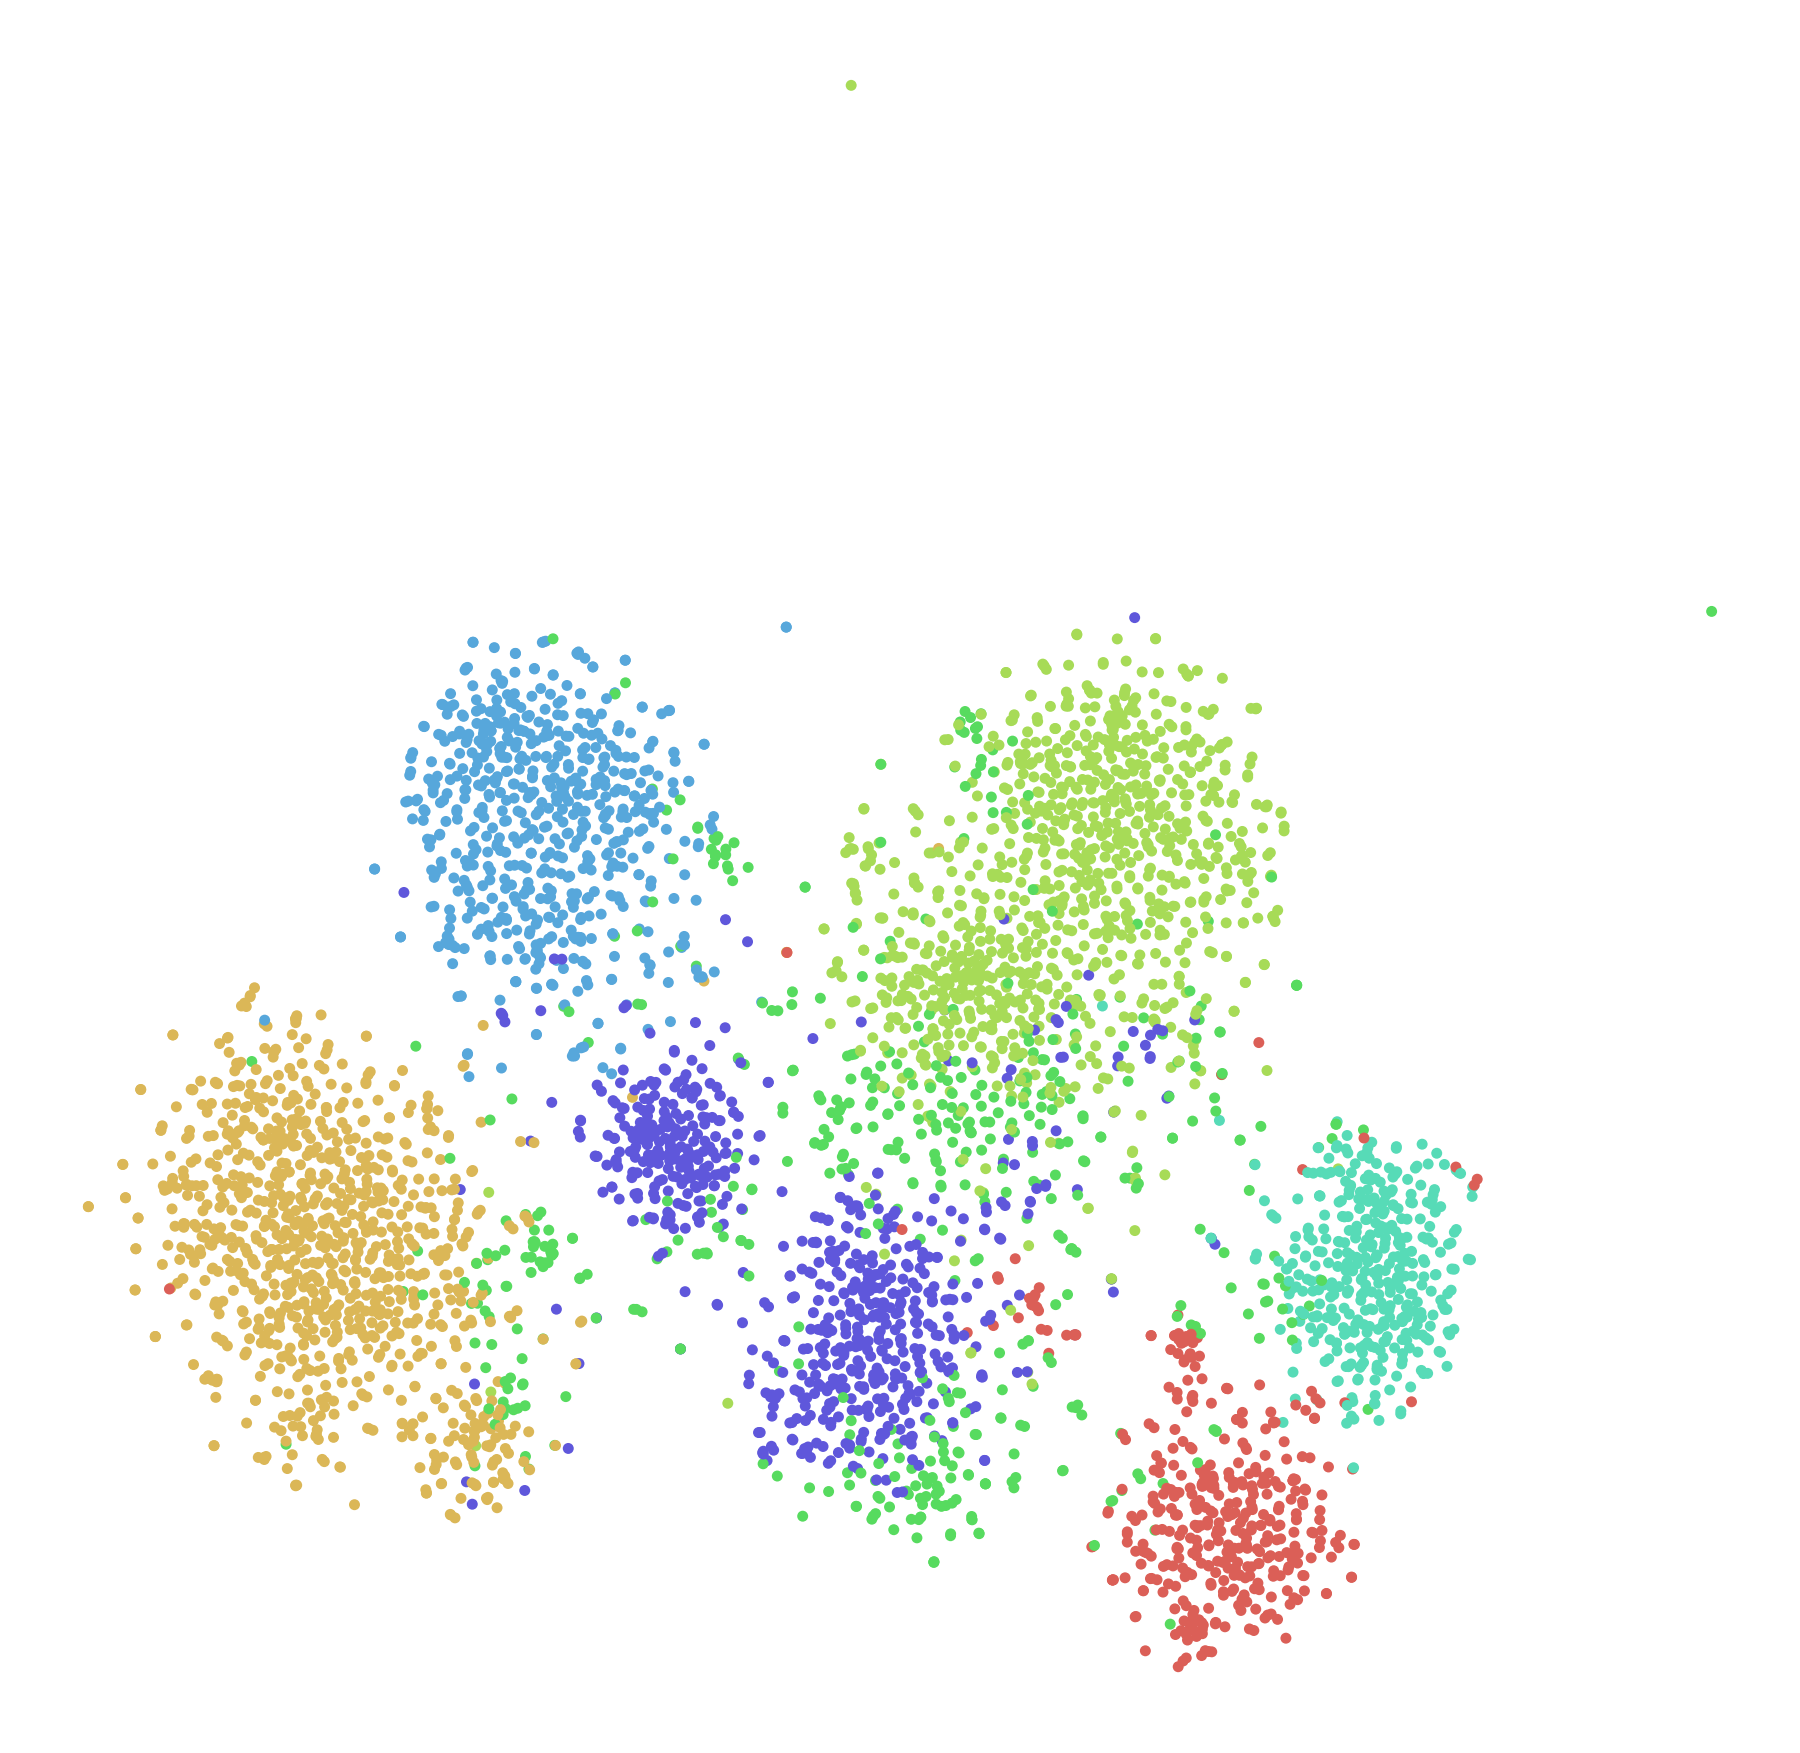

In [49]:
print(list(range(0,7)))
sns.palplot(np.array(sns.color_palette("hls",9)))
scatter(tsne_model, Y)

## END